In [1]:
!! pip install pytreebank==0.2.7


['Collecting pytreebank==0.2.7',
 '  Downloading https://files.pythonhosted.org/packages/e0/12/626ead6f6c0a0a9617396796b965961e9dfa5e78b36c17a81ea4c43554b1/pytreebank-0.2.7.tar.gz',
 'Building wheels for collected packages: pytreebank',
 '  Building wheel for pytreebank (setup.py) ... \x1b[?25l\x1b[?25hdone',
 '  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=1b2efaa1309e579b74acf1547447131e787fdca1e64f8ca255681bed853ef9f5',
 '  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368',
 'Successfully built pytreebank',
 'Installing collected packages: pytreebank',
 'Successfully installed pytreebank-0.2.7']

In [2]:
!pip install google_trans_new

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')

import pytreebank

import google_trans_new 
from google_trans_new import google_translator  
import random

#from sklearn.model_selection import train_test_split

import os, pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Get Dataset

In [4]:
# load the sentiment treebank corpus in the parenthesis format,
# ["very negative", "negative", "neutral", "positive", "very positive"][label]
dataset = pytreebank.load_sst()

In [5]:
data_train = [example.to_labeled_lines()[0] for example in dataset["train"]]
data_test = [example.to_labeled_lines()[0] for example in dataset["test"]]

In [6]:
len(data_train), len(data_test)

(8544, 2210)

In [7]:
train = pd.DataFrame(data_train, columns = ['label', 'sentence'])
test = pd.DataFrame(data_test, columns = ['label', 'sentence'])

In [8]:
train.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


## Augment Data

### Back Translation

In [9]:
def back_translate(sentence):
  """ Google translate the input sentence and translate back"""
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  translator = google_translator()  
  translate_text = translator.translate(sentence,lang_tgt=trans_lang) 
  translate_back = translator.translate(translate_text,lang_tgt='en')

  return (translate_back)

In [10]:
# test function 
sentence = ' Pulling out the classic Amazon Mechanical Turk workers, the authors presented these phrases in a random order and asked annotators to indicate the sentiment and degree of sentiment for each phrase using a slider.'
text = back_translate(sentence)

In [11]:
print(text)

The drawing of classical amazon mechanical workers, the authors presented these phrases in random order and requested annotators to indicate the feeling and degree of sentiment for each phrase using the slider. 


### Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [12]:
def random_deletion(sentence, p=0.5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return (' '.join(remaining))

In [13]:
test_rd = random_deletion(sentence, p=0.5)

In [14]:
test_rd

'Pulling out classic Amazon the authors these phrases in a order annotators sentiment and degree sentiment slider.'

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.



In [15]:
def random_swap(sentence, n=5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    length = range(len(words)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 
    return (' '.join(words))

In [16]:
test_rs = random_swap(sentence, n=5)
test_rs

'Pulling out the classic presented Mechanical Turk Amazon the authors a these phrases in workers, random order and asked annotators slider. indicate the each and degree of sentiment for sentiment phrase using a to'

## Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.)


In [17]:
stop_words = set(stopwords.words('english'))

def random_insertion(sentence, n=3): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    words = [w for w in words if not w.lower() in stop_words]
    for _ in range(n):
        word = random.choice(words)
        synonym = wordnet.synsets(word)
        if len(synonym) > 0:
          sentence.replace(word, synonym[0].lemmas()[0].name())
    return sentence

In [18]:
test_ri = random_insertion(sentence, n=3)
test_ri

' Pulling out the classic Amazon Mechanical Turk workers, the authors presented these phrases in a random order and asked annotators to indicate the sentiment and degree of sentiment for each phrase using a slider.'

## Generate Augmented Data

In [19]:
# Back Translate
df_part1 = train.sample( frac=.05)
df_part1['sentence'] = df_part1['sentence'].apply(lambda x: back_translate(x))
df_part1.head()

In [20]:
# Random Deletion
df_part2 = train.sample(frac=.5)
df_part2 ['sentence'] = df_part2['sentence'].apply(lambda x: random_deletion(x))
df_part2.head()

,label,sentence
5374,1,It long bore
5297,0,"Contrived , unintended the shows someone than ..."
2116,3,"'re out marathons and with A , might the movie..."
3279,4,'s the kind of effectively that has corner of ...
2335,3,film with a more down-home flavor .


In [21]:
# Random Swap
df_part3 = train.sample(frac=.5)
df_part3 ['sentence'] = df_part3['sentence'].apply(lambda x: random_swap(x))
df_part3.head()

,label,sentence
5431,3,It than better The 's Menace Phantom .
4405,1,It 's mildly interesting to ponder the peculia...
4439,0,"As mile over-the-top John , has trash beat mov..."
1773,3,even is seems to have directly how this girl-m...
616,3,"In all for , I must report that children the o..."


In [22]:
# Random Insertion
df_part4 = train.sample(frac=.5)
df_part4 ['sentence'] = df_part4['sentence'].apply(lambda x: random_insertion(x))
df_part4.head()

,label,sentence
1100,3,"Alternately hilarious and sad , aggravating an..."
6260,2,If you adored The Full Monty so resoundingly t...
5758,1,Any rock pile will do for a set .
5668,2,but ` Why ? '
6665,1,Strictly a ` guy 's film ' in the worst sense ...


In [23]:
# train_final = pd.concat([train,df_part1,df_part2,df_part3, df_part4], ignore_index=True)
train_final = pd.concat([train,df_part2,df_part3, df_part4], ignore_index=True)

In [24]:
train_final.shape

(21360, 2)

In [25]:
train_final.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


In [26]:
train_final['label'].value_counts()

3    5845
1    5492
2    4068
4    3245
0    2710
Name: label, dtype: int64

### Serialize the dataframe 

In [28]:
with open('train_final.pkl', 'wb') as train_set: 
    pickle.dump(train_final, train_set)

[Text(0.5, 0, 'Labels')]

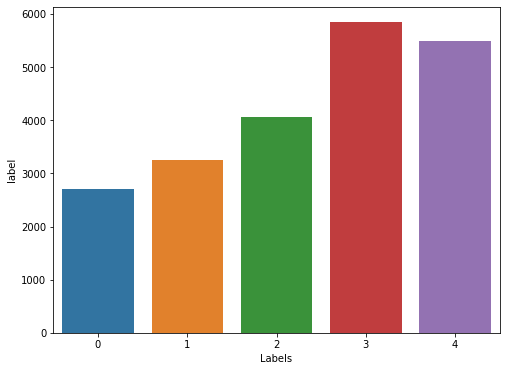

In [27]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=train_final['label'].unique(), y=train_final['label'].value_counts())

ax.set(xlabel = 'Labels')

### We have got imbalanced dataset, better to agument data in under populated classes

### Tokenize the data

In [28]:
train_final.to_csv('train_final.csv', index=False)
test.to_csv('test.csv', index=False)

In [29]:
def text_clean(text):
  text = re.sub(r'[^A-Za-z0-9_-]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)

  return(text.strip())

In [30]:
nlp = spacy.load('en', disable = ['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(text_clean(s))]

In [31]:
TEXT = torchtext.legacy.data.Field(tokenize = tokenizer)

LABEL = torchtext.legacy.data.LabelField(dtype = torch.float)

In [32]:
datafields = [('label', LABEL), ('sentence', TEXT)]

In [33]:
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='/content/session5',
                                                       train = 'train_final.csv',
                                                       test = 'test.csv',
                                                       format = 'csv',
                                                       skip_header = True,
                                                       fields = datafields
                                                       )

In [34]:
trn[:5]

In [35]:
print(f'Number of examples in training {len(trn)}')
print(f'Number of examples in test {len(tst)}')

Number of examples in training 21360
Number of examples in test 2210


In [36]:
trn[5].__dict__.keys()

dict_keys(['label', 'sentence'])

In [37]:
trn[5].sentence, trn[5].label

(['whether',
  'or',
  'not',
  'you',
  're',
  'enlightened',
  'by',
  'any',
  'of',
  'derrida',
  's',
  'lectures',
  'on',
  'the',
  'other',
  'and',
  'the',
  'self',
  'derrida',
  'is',
  'an',
  'undeniably',
  'fascinating',
  'and',
  'playful',
  'fellow'],
 '4')

In [38]:
print(vars(trn[5]))

{'label': '4', 'sentence': ['whether', 'or', 'not', 'you', 're', 'enlightened', 'by', 'any', 'of', 'derrida', 's', 'lectures', 'on', 'the', 'other', 'and', 'the', 'self', 'derrida', 'is', 'an', 'undeniably', 'fascinating', 'and', 'playful', 'fellow']}


In [39]:
words = [0 + len(t.sentence) for t in trn]

In [40]:
sum(words)

341280

In [41]:
TEXT.build_vocab(trn, max_size = 18000,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_ )

LABEL.build_vocab(trn) 

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399099/400000 [00:13<00:00, 28400.33it/s]

### Serialize Vocab

In [42]:
with open('TEXT.pkl', 'wb') as text: 
    pickle.dump(TEXT, text)

In [43]:
with open('LABEL.pkl', 'wb') as label: 
    pickle.dump(LABEL, label)

In [44]:
print(TEXT.vocab.freqs.most_common(50))

[('the', 16620), ('a', 11976), ('of', 10117), ('and', 10116), ('to', 6805), ('-', 6223), ('s', 5813), ('is', 5807), ('it', 5441), ('that', 4389), ('in', 4322), ('as', 2853), ('film', 2637), ('but', 2618), ('with', 2605), ('for', 2315), ('movie', 2264), ('this', 2216), ('an', 2201), ('its', 2138), ('you', 1920), ('t', 1597), ('n', 1575), ('on', 1494), ('be', 1474), ('not', 1384), ('one', 1314), ('by', 1274), ('has', 1210), ('about', 1201), ('more', 1192), ('like', 1175), ('at', 1157), ('are', 1150), ('from', 1141), ('--', 1139), ('than', 1113), ('all', 1097), ('have', 1065), ('his', 967), ('so', 952), ('i', 945), ('if', 907), ('or', 855), ('story', 809), ('out', 781), ('what', 770), ('who', 745), ('there', 737), ('too', 711)]


In [45]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'of', 'and', 'to', '-', 's', 'is']


In [46]:
print(LABEL.vocab.stoi)

defaultdict(None, {'3': 0, '1': 1, '2': 2, '4': 3, '0': 4})


In [82]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                                                            (trn, tst),
                                                                            batch_size = BATCH_SIZE,
                                                                            sort_key = lambda x: len(x.sentence),
                                                                            sort_within_batch= True, 
                                                                            device = device)

In [83]:
class RNN(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers,
                      bidirectional = bidirectional, dropout = dropout )
    
    self.fc = nn.Linear(hidden_dim*2, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded =  self.dropout(self.embedding(text))

    output, hidden = self.rnn(embedded)

    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

    return self.fc(hidden.squeeze(0))

In [84]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim  = 256

output_dim = 5

num_layers = 2

bidirectional = True

dropout = .4

In [85]:
model = RNN(input_dim, 
            embedding_dim,
            hidden_dim,
            output_dim,
            num_layers,
            bidirectional,
            dropout)

In [86]:
model

RNN(
  (embedding): Embedding(15358, 100)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [87]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([15358, 100])


In [88]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.1689, -1.1809,  0.1555,  ..., -0.2434, -0.3489,  1.3271],
        [-1.8369, -1.1993,  0.8885,  ...,  0.2879,  0.3148, -0.3080],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0635,  0.1009,  0.2432,  ...,  0.3273, -0.3251,  0.1559],
        [ 0.2153,  0.4650,  0.3468,  ...,  0.2906,  0.0631, -0.4491],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842]])

In [89]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0635,  0.1009,  0.2432,  ...,  0.3273, -0.3251,  0.1559],
        [ 0.2153,  0.4650,  0.3468,  ...,  0.2906,  0.0631, -0.4491],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842]])


In [98]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,270,973 trainable parameters


In [90]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [91]:
# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [92]:
# def train(model, iterator, optimizer, cretrion):

#   epoch_loss = 0
#   epoch_acc = 0

#   model.train()

#   for batch in iterator:

#     optimizer.zero_grad()

#     predictions = model(batch.sentence).squeeze(1)

#     # predictions = torch.argmax(predictions,1)

#     print(predictions, batch.label)

#     loss = criterion(predictions, batch.label.float())

#     # rounded_preds = torch.round(torch.sigmoid(predictions))
#     correct = (predictions == batch.label).float()

#     acc = correct.sum() / len(correct)

#     loss.backward()

#     optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()

#   return epoch_loss / len(iterator) , epoch_acc / len(iterator)

In [93]:
# num_epochs = 1

# for epoch in range(num_epochs):
#   train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
#   print(f'| Epoch: {epoch+1:02}  | Train Loss: {train_loss: .3f}  | Train Accuracy: {train_acc*100: .2f}%')

In [94]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
               
        # convert to 1D tensor
        predictions = model(batch.sentence).squeeze(1)
        
        # compute the loss
        loss = criterion(predictions, batch.label.long())        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label.long())   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [95]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
                   
            # convert to 1d tensor
            predictions = model(batch.sentence).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label.long())
            acc = binary_accuracy(predictions, batch.label.long())
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [96]:
N_EPOCHS = 200

best_test_loss = float('inf')

trn_loss = [] 
trn_acc = []
tst_loss = [] 
tst_acc = [] 

for epoch in range(N_EPOCHS):

    if epoch > 50:
      optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    if epoch > 100:
      optimizer = optim.Adam(model.parameters(), lr = 1e-3)

     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    trn_loss.append(train_loss)
    trn_acc.append(train_acc*100)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    tst_loss.append(test_loss)
    tst_acc.append(test_acc*100)
    
    # # save the best model
    # if test_loss < best_test_loss:
    #     best_test_loss = test_loss
    #     torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

Epoch: 1
	Train Loss: 1.582 | Train Acc: 25.83%
	 Val. Loss: 1.578 |  Val. Acc: 25.16% 

Epoch: 2
	Train Loss: 1.564 | Train Acc: 28.22%
	 Val. Loss: 1.573 |  Val. Acc: 25.31% 

Epoch: 3
	Train Loss: 1.561 | Train Acc: 29.01%
	 Val. Loss: 1.569 |  Val. Acc: 26.98% 

Epoch: 4
	Train Loss: 1.557 | Train Acc: 29.93%
	 Val. Loss: 1.562 |  Val. Acc: 29.83% 

Epoch: 5
	Train Loss: 1.550 | Train Acc: 30.80%
	 Val. Loss: 1.557 |  Val. Acc: 29.40% 

Epoch: 6
	Train Loss: 1.544 | Train Acc: 31.56%
	 Val. Loss: 1.548 |  Val. Acc: 31.67% 

Epoch: 7
	Train Loss: 1.535 | Train Acc: 31.76%
	 Val. Loss: 1.537 |  Val. Acc: 32.60% 

Epoch: 8
	Train Loss: 1.523 | Train Acc: 32.70%
	 Val. Loss: 1.522 |  Val. Acc: 33.30% 

Epoch: 9
	Train Loss: 1.509 | Train Acc: 33.54%
	 Val. Loss: 1.502 |  Val. Acc: 33.81% 

Epoch: 10
	Train Loss: 1.491 | Train Acc: 34.17%
	 Val. Loss: 1.474 |  Val. Acc: 35.50% 

Epoch: 11
	Train Loss: 1.473 | Train Acc: 35.04%
	 Val. Loss: 1.450 |  Val. Acc: 36.50% 

Epoch: 12
	Train Lo

## Train test logs

Text(0.5, 1.0, 'Accuracy')

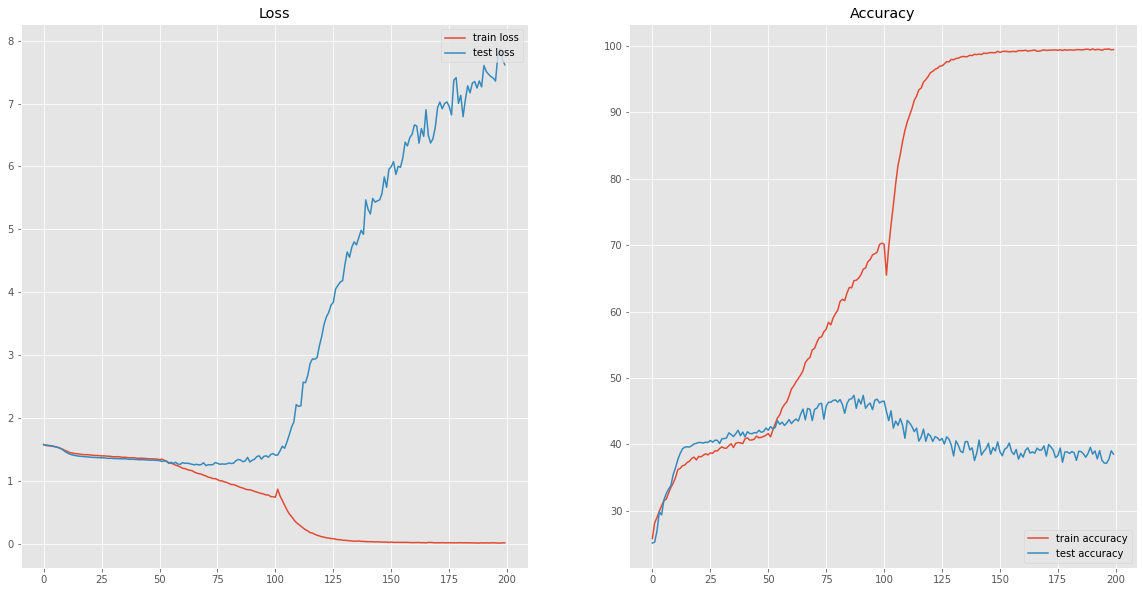

In [97]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(trn_loss, label = 'train loss')
axs[0].plot(tst_loss, label = 'test loss')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")

axs[1].plot(trn_acc,  label = 'train accuracy')
axs[1].plot(tst_acc,  label = 'test accuracy')
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")